In [57]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.autograd import Variable
import torch
from torchvision import transforms
import math

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [8]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(array([4132., 4684., 4177., 4351., 4072., 3795., 4137., 4401., 4063.,
        4188.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

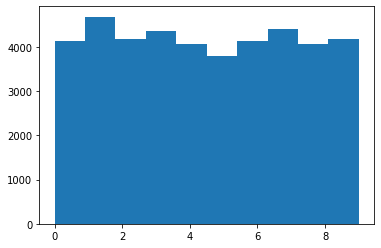

In [9]:
#Plot a histogram of the different hand written didgets

plt.hist(train.iloc[:, 0])

In [11]:
mean = train.mean()
std =  train.std()

In [28]:
classes = np.sort(train.iloc[:, 0].unique())
print(classes)

[0 1 2 3 4 5 6 7 8 9]


In [140]:
#This function will get the image and turn it into a tensor and return the tensor and data label of a given 
# row
def get_image(data = train, row = 0):
    image = train.iloc[row,1:]
    label = train.iloc[row, 0]
    image = torch.tensor(image).view(28,28)
    return image, label


def to_tensor(data = train, row = 0):
    image = train.iloc[row,1:]
    image = torch.tensor(image).type(torch.float).view(1,1,28,28)
    return image

#This function takes a tensor input and the data label and prints the image
def show_image(image, label):
    #img = np.moveaxis(image,0, -1)
    print("The image is:", label)
    
    plt.imshow(image)
    plt.show()
    

The image is: 8


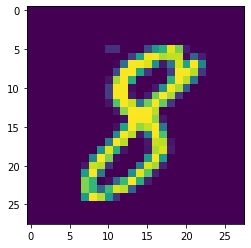

In [56]:
image, label = get_image(row = 20)
show_image(image, label)
#print(image)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [122]:
#Network Time

#A new neural network set up for cool guys (or girls)
class cgNet(nn.Module):
    def __init__(self):
        super(cgNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 3, kernel_size = 3)
        
        self.pool = nn.MaxPool2d(2,2)
    
        self.fc1 = nn.Linear(13*13*3, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        print(x.shape)
        x = x.view(-1, 13*13*3)
        print(x.shape)
        #x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()
        num_features = 1
        for s in size:
            num_features *= s
        print(num_features)
        return num_features
        

In [143]:
#Manual pass through network to see that it works and output type
network = cgNet()

#initialize some weights
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    if type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

network.apply(init_weights)

image = to_tensor(train, 20)
out = network(torch.Tensor(image))
print(out)

torch.Size([1, 3, 13, 13])
torch.Size([1, 507])
tensor([[ 41.5365,  23.4084,  17.8302,   1.6782,  20.3856,  16.0472, -33.2525,
          -5.4762,   4.6196, -16.8992]], grad_fn=<AddmmBackward>)


torch.Size([1, 1, 28, 28])